In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


import missingno as msno
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style="darkgrid",font_scale=1.5)
pd.set_option("display.max.columns",None)
pd.set_option("display.max.rows",None)
# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress user warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress future warnings

# Suppress specific warnings for LGBMClassifier and CatBoostClassifier
import logging
logging.getLogger("catboost").setLevel(logging.ERROR)  # Suppress CatBoost logs
logging.getLogger("lightgbm").setLevel(logging.ERROR)  # Suppress LightGBM logs

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import label_binarize
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

**Loading Dataset**

In [5]:
df = pd.read_csv('/content/Obesity prediction.csv')

In [6]:
df.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


**Exploratory data analysis**

In [7]:
df.shape

(2111, 17)

In [8]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history', 'FAVC', 'FCVC',
       'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS',
       'Obesity'],
      dtype='object')

In [9]:
# Rename columns using a dictionary
new_column_names = {
    'Gender': 'GENDER',
    'Age': 'AGE',
    'Height': 'HEIGHT',
    'Weight': 'WEIGHT',
    'family_history': 'FAMILY_HISTORY',
    'FAVC': 'FAVC',
    'FCVC': 'FCVC',
    'NCP': 'NCP',
    'CAEC': 'CAEC',
    'SMOKE': 'SMOKE',
    'CH2O': 'CH2O',
    'SCC': 'SCC',
    'FAF': 'FAF',
    'TUE': 'TUE',
    'CALC': 'CALC',
    'MTRANS': 'MTRANS',
    'Obesity': 'OBESITY'
    }
df = df.rename(columns=new_column_names)

In [10]:
df.head()

,GENDER,AGE,HEIGHT,WEIGHT,FAMILY_HISTORY,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,OBESITY
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GENDER          2111 non-null   object 
 1   AGE             2111 non-null   float64
 2   HEIGHT          2111 non-null   float64
 3   WEIGHT          2111 non-null   float64
 4   FAMILY_HISTORY  2111 non-null   object 
 5   FAVC            2111 non-null   object 
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   object 
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   object 
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  OBESITY         2111 non-null   object 
dtypes: float64(8), object(9)
memory u

In [12]:
df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})

,Total No. of Missing Values
GENDER,0
AGE,0
HEIGHT,0
WEIGHT,0
FAMILY_HISTORY,0
FAVC,0
FCVC,0
NCP,0
CAEC,0
SMOKE,0


In [13]:
print("Duplicate Values =",df.duplicated().sum())

Duplicate Values = 24


In [14]:
df.drop_duplicates(inplace=True)

In [15]:
print("Duplicate Values =",df.duplicated().sum())

Duplicate Values = 0


In [16]:
df.shape

(2087, 17)

In [17]:
numeric_data = df.select_dtypes(include=[np.number])
numeric_data.head()

,AGE,HEIGHT,WEIGHT,FCVC,NCP,CH2O,FAF,TUE
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0
1,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0
2,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0
3,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0
4,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0


In [18]:
categorical_data = df.select_dtypes(exclude=[np.number])
categorical_data.head()

,GENDER,FAMILY_HISTORY,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,OBESITY
0,Female,yes,no,Sometimes,no,no,no,Public_Transportation,Normal_Weight
1,Female,yes,no,Sometimes,yes,yes,Sometimes,Public_Transportation,Normal_Weight
2,Male,yes,no,Sometimes,no,no,Frequently,Public_Transportation,Normal_Weight
3,Male,no,no,Sometimes,no,no,Frequently,Walking,Overweight_Level_I
4,Male,no,no,Sometimes,no,no,Sometimes,Public_Transportation,Overweight_Level_II


In [19]:
numeric_data.corr()

,AGE,HEIGHT,WEIGHT,FCVC,NCP,CH2O,FAF,TUE
AGE,1.000000,-0.031748,0.198160,0.013572,-0.055823,-0.044058,-0.148202,-0.302927
HEIGHT,-0.031748,1.000000,0.457468,-0.040363,0.227806,0.220487,0.293584,0.041808
WEIGHT,0.198160,0.457468,1.000000,0.216574,0.092149,0.203823,-0.056490,-0.079351
FCVC,0.013572,-0.040363,0.216574,1.000000,0.034885,0.081332,0.022003,-0.104128
NCP,-0.055823,0.227806,0.092149,0.034885,1.000000,0.075335,0.127816,0.015693
CH2O,-0.044058,0.220487,0.203823,0.081332,0.075335,1.000000,0.165310,0.020704
FAF,-0.148202,0.293584,-0.056490,0.022003,0.127816,0.165310,1.000000,0.058716
TUE,-0.302927,0.041808,-0.079351,-0.104128,0.015693,0.020704,0.058716,1.000000


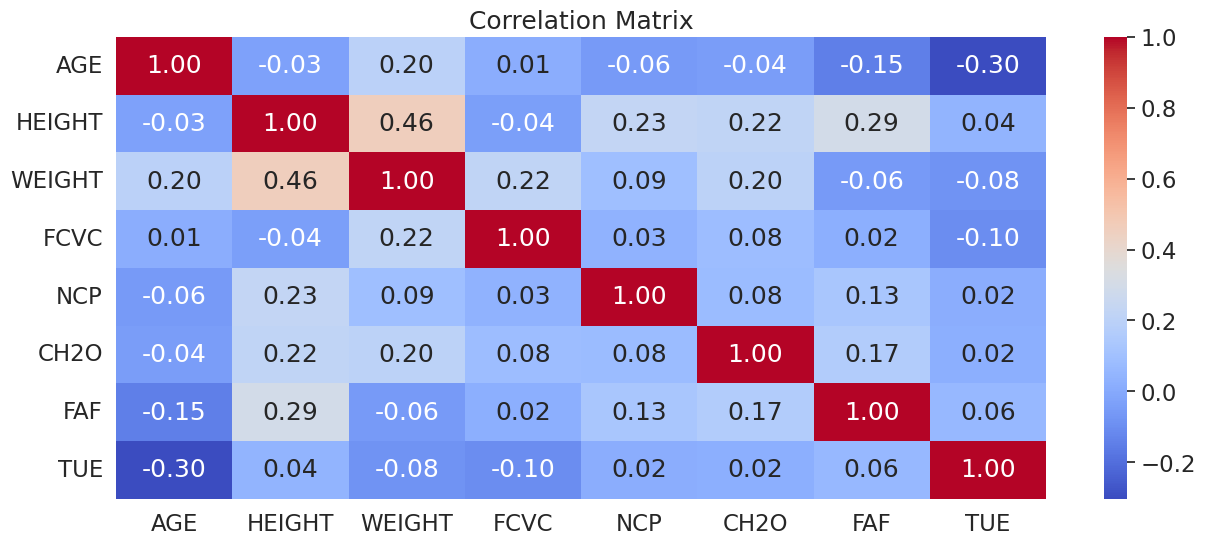

In [20]:
# Create the heatmap
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

**Data visualization**

In [21]:
categorical_columns = df.select_dtypes(include="object").columns.tolist()
for col in categorical_columns:
    print(f"{col} : value and frequency")
    print(df[col].value_counts())
    print("-"*50)

GENDER : value and frequency
GENDER
Male      1052
Female    1035
Name: count, dtype: int64
--------------------------------------------------
FAMILY_HISTORY : value and frequency
FAMILY_HISTORY
yes    1722
no      365
Name: count, dtype: int64
--------------------------------------------------
FAVC : value and frequency
FAVC
yes    1844
no      243
Name: count, dtype: int64
--------------------------------------------------
CAEC : value and frequency
CAEC
Sometimes     1761
Frequently     236
Always          53
no              37
Name: count, dtype: int64
--------------------------------------------------
SMOKE : value and frequency
SMOKE
no     2043
yes      44
Name: count, dtype: int64
--------------------------------------------------
SCC : value and frequency
SCC
no     1991
yes      96
Name: count, dtype: int64
--------------------------------------------------
CALC : value and frequency
CALC
Sometimes     1380
no             636
Frequently      70
Always           1
Name: count,

**Feature engineering and scaling**

In [26]:
# Create BMI
df["BMI"] = df["WEIGHT"] / (df["HEIGHT"] ** 2)
df.head()

,GENDER,AGE,HEIGHT,WEIGHT,FAMILY_HISTORY,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,OBESITY,BMI
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,24.386526
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,24.238227
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,23.765432
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,26.851852
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,28.342381


In [27]:
df = df.drop(["WEIGHT", "HEIGHT"], axis=1)

In [28]:
df.head()

,GENDER,AGE,FAMILY_HISTORY,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,OBESITY,BMI
0,Female,21.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,24.386526
1,Female,21.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,24.238227
2,Male,23.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,23.765432
3,Male,27.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,26.851852
4,Male,22.0,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,28.342381


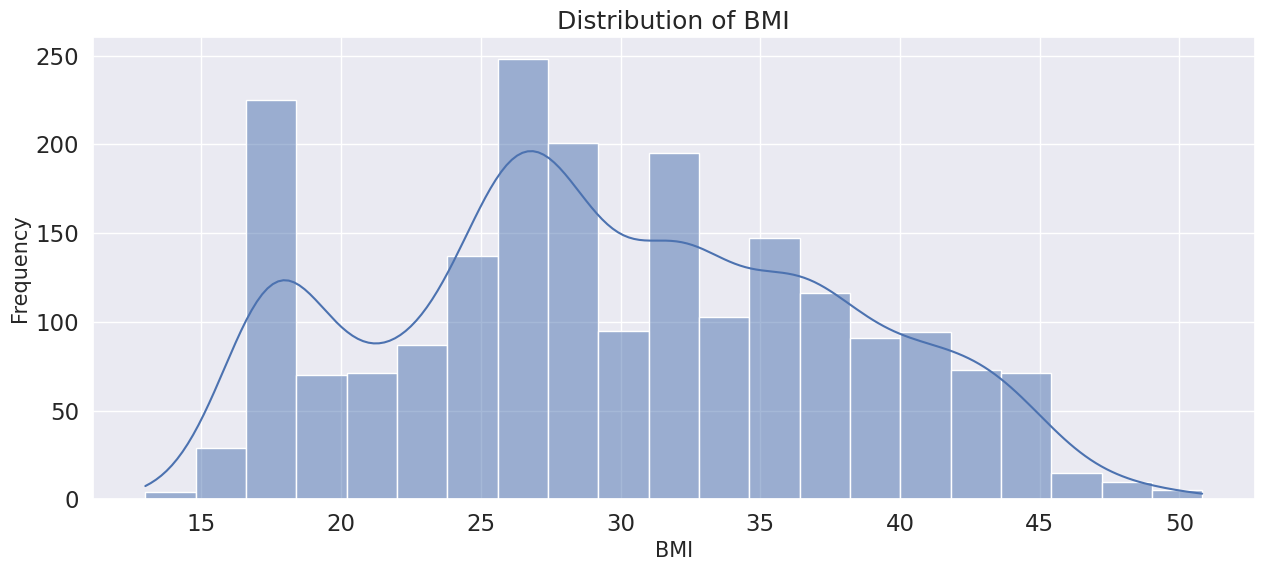

In [29]:
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
sns.histplot(df, x='BMI', kde=True)
plt.title(f"Distribution of BMI")
plt.xlabel("BMI", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show()

In [30]:
# Ordinal Encoding
category_column = ["GENDER","FAMILY_HISTORY","FAVC","CAEC","SMOKE","SCC","CALC"]

In [31]:
oe = OrdinalEncoder()
df[category_column] = oe.fit_transform(df[category_column])
df.head()

,GENDER,AGE,FAMILY_HISTORY,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,OBESITY,BMI
0,0.0,21.0,1.0,0.0,2.0,3.0,2.0,0.0,2.0,0.0,0.0,1.0,3.0,Public_Transportation,Normal_Weight,24.386526
1,0.0,21.0,1.0,0.0,3.0,3.0,2.0,1.0,3.0,1.0,3.0,0.0,2.0,Public_Transportation,Normal_Weight,24.238227
2,1.0,23.0,1.0,0.0,2.0,3.0,2.0,0.0,2.0,0.0,2.0,1.0,1.0,Public_Transportation,Normal_Weight,23.765432
3,1.0,27.0,0.0,0.0,3.0,3.0,2.0,0.0,2.0,0.0,2.0,0.0,1.0,Walking,Overweight_Level_I,26.851852
4,1.0,22.0,0.0,0.0,2.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,Public_Transportation,Overweight_Level_II,28.342381


In [33]:
df = pd.get_dummies(columns=["MTRANS"],data=df,drop_first=True)

In [34]:
boolean_cols_auto = df.select_dtypes(include=['bool']).columns
df[boolean_cols_auto] = df[boolean_cols_auto].astype(int)

In [35]:
le = LabelEncoder()
df["OBESITY"] = le.fit_transform(df["OBESITY"])

In [36]:
df.head()

,GENDER,AGE,FAMILY_HISTORY,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,OBESITY,BMI,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.0,21.0,1.0,0.0,2.0,3.0,2.0,0.0,2.0,0.0,0.0,1.0,3.0,1,24.386526,0,0,1,0
1,0.0,21.0,1.0,0.0,3.0,3.0,2.0,1.0,3.0,1.0,3.0,0.0,2.0,1,24.238227,0,0,1,0
2,1.0,23.0,1.0,0.0,2.0,3.0,2.0,0.0,2.0,0.0,2.0,1.0,1.0,1,23.765432,0,0,1,0
3,1.0,27.0,0.0,0.0,3.0,3.0,2.0,0.0,2.0,0.0,2.0,0.0,1.0,5,26.851852,0,0,0,1
4,1.0,22.0,0.0,0.0,2.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,6,28.342381,0,0,1,0


**Machine learning models for prediction**

In [37]:
x = df.drop(['OBESITY'], axis = 1)
y = df['OBESITY']

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)

In [39]:
print("x_train - >  ",x_train.shape)
print("y_train - >  ",y_train.shape)
print("x_test  - >  ",x_test.shape)
print("y_test  - >  ",y_test.shape)

x_train - >   (1669, 18)
y_train - >   (1669,)
x_test  - >   (418, 18)
y_test  - >   (418,)


In [40]:
ss = StandardScaler()

In [41]:
x_train_scaled = ss.fit_transform(x_train)
x_test_scaled = ss.transform(x_test)

In [42]:
train_accuracy_scores = []
train_precision_scores = []
train_recall_scores = []
train_f1_scores = []

test_accuracy_scores = []
test_precision_scores = []
test_recall_scores = []
test_f1_scores = []

In [43]:
def evaluate_classification_performance(model, x_train, y_train, x_test, y_test, score_append=False):
    """
    Evaluate the performance of a classification model on training and test datasets for multiclass problems.
    Plots confusion matrices for both datasets.

    Args:
        model: Trained classification model.
        x_train: Features for training set.
        y_train: True labels for training set.
        x_test: Features for test set.
        y_test: True labels for test set.
        score_append: If True, appends the scores to global lists.

    Returns:
        A dictionary with performance metrics for training and test sets.
    """
    # Fit the model
    model.fit(x_train, y_train)

    # Predict on train and test datasets
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics for the training set
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')

    # Calculate metrics for the test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Optionally append scores to global lists
    if score_append:
        train_accuracy_scores.append(train_accuracy)
        train_precision_scores.append(train_precision)
        train_recall_scores.append(train_recall)
        train_f1_scores.append(train_f1)

        test_accuracy_scores.append(test_accuracy)
        test_precision_scores.append(test_precision)
        test_recall_scores.append(test_recall)
        test_f1_scores.append(test_f1)

    # Generate confusion matrices
    train_cm = confusion_matrix(y_train, y_train_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)

    # Plot confusion matrices
    def plot_confusion_matrix(cm, title, labels):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title(title)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    print(f"{model.__class__.__name__} Performance Metrics:")
    print(f"Training Data: Accuracy = {train_accuracy:.2f}, Precision = {train_precision:.2f}, Recall = {train_recall:.2f}, F1-score = {train_f1:.2f}")
    print(f"Testing Data : Accuracy = {test_accuracy:.2f}, Precision = {test_precision:.2f}, Recall = {test_recall:.2f}, F1-score = {test_f1:.2f}\n")
    class_labels = sorted(set(y_train))  # Extract class labels

    print("Training Confusion Matrix:")
    plot_confusion_matrix(train_cm, "Training Confusion Matrix", class_labels)

    print("Testing Confusion Matrix:")
    plot_confusion_matrix(test_cm, "Testing Confusion Matrix", class_labels)

RandomForestClassifier Performance Metrics:
Training Data: Accuracy = 1.00, Precision = 1.00, Recall = 1.00, F1-score = 1.00
Testing Data : Accuracy = 0.97, Precision = 0.98, Recall = 0.97, F1-score = 0.97

Training Confusion Matrix:


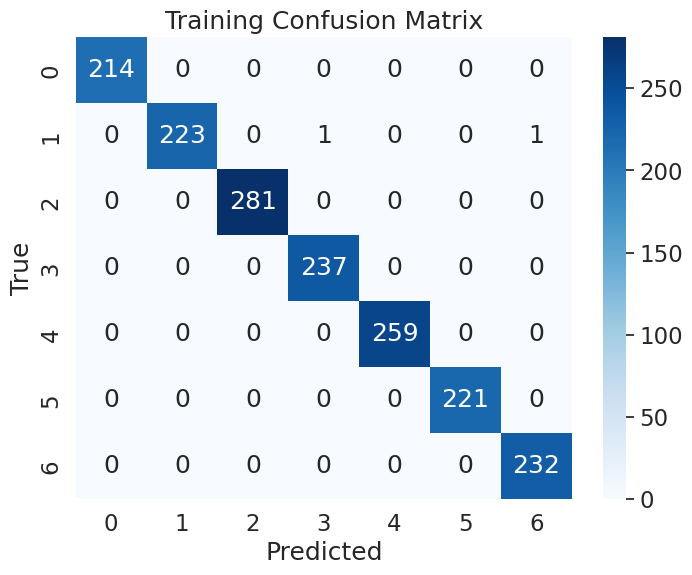

Testing Confusion Matrix:


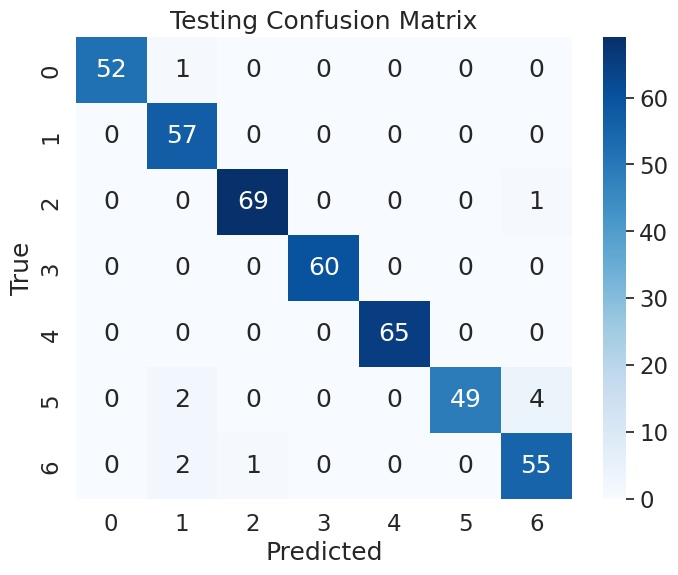

In [46]:
evaluate_classification_performance(
    model=RandomForestClassifier(n_estimators=10,max_depth=10,n_jobs=-1),
    x_train=x_train_scaled,
    y_train=y_train,
    x_test=x_test_scaled,
    y_test=y_test,
    score_append = True
)

XGBClassifier Performance Metrics:
Training Data: Accuracy = 1.00, Precision = 1.00, Recall = 1.00, F1-score = 1.00
Testing Data : Accuracy = 0.99, Precision = 0.99, Recall = 0.99, F1-score = 0.99

Training Confusion Matrix:


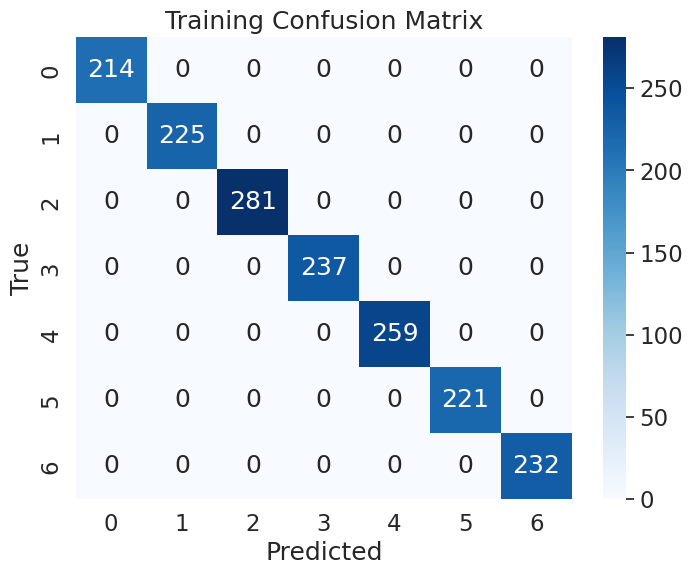

Testing Confusion Matrix:


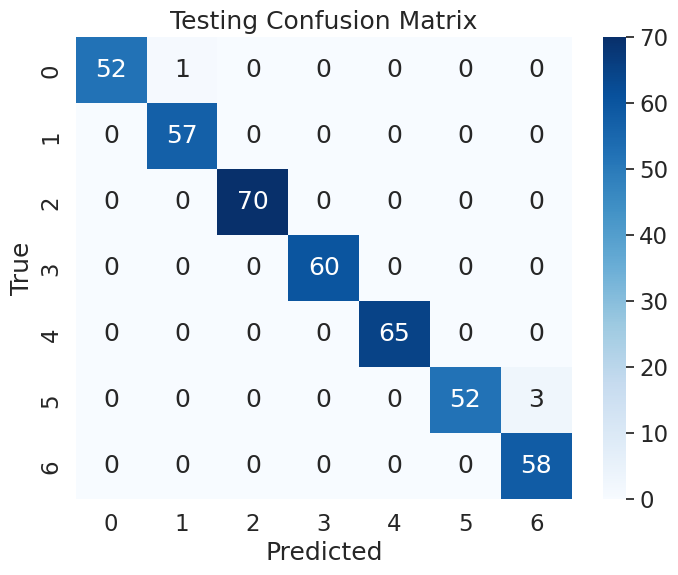

In [47]:
evaluate_classification_performance(
    model=XGBClassifier(),
    x_train=x_train_scaled,
    y_train=y_train,
    x_test=x_test_scaled,
    y_test=y_test,
    score_append = True
)